# **1. Download das Bibliotecas**

In [1]:
#%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1

In [2]:
#%pip install matplotlib yfinance scikit-learn scikit-optimize

# **2. Importações**

## Geral

In [3]:
# Importação de libs auxiliares
import numpy as np
import pandas as pd

# Importando as classes refatoradas
from preprocessamento.SeriesProcessor import SeriesProcessor
from otimizador.Optimizer import OtimizadorModelosSklearn
from avaliacao.AvaliadorDriftBase import AvaliadorBatch
from avaliacao.AvaliadorDriftBase import AvaliadorPassivo
from avaliacao.AvaliadorDriftBase import AvaliadorPassivoDrift
from utils.Visualizer import Visualizer

# limpar o log
import warnings
warnings.filterwarnings("ignore")

## Importação dos Detectores e Regressores Off-line e On-line

In [4]:
# importando o framework
from frame_oasis.OASIS import OASIS
from frame_winks.WinKS import WinKS

In [5]:
# Importando detectores de drift
from detectores.ADWINDetector import ADWINDetector
from detectores.DDMDetector import DDMDetector
from detectores.EDDMDetector import EDDMDetector
from detectores.FHDDMDetector import FHDDMDetector
from detectores.HDDM_ADetector import HDDM_ADetector
from detectores.PageHinkleyDetector import PageHinkleyDetector
from detectores.HDDM_WDetector import HDDM_WDetector
from detectores.KSWINDetector import KSWINDetector

In [6]:
# Importando modelos offline
from regressores.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from regressores.modelosOffline.KneighborsRegressorModelo import KneighborsRegressorModelo
from regressores.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from regressores.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from regressores.modelosOffline.SVRModelo import SVRModelo
from regressores.modelosOffline.RandomForestModelo import RandomForestModelo
from regressores.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

In [7]:
# Importando modelos online
from regressores.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo
from regressores.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo
from regressores.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo
from regressores.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo
from regressores.modelosOnline.MLPRegressorOnlineModelo import MLPRegressorOnlineModelo
from regressores.modelosOnline.OSELM import OSELMModelo

# **3. Dados e Pré-processamento**

## Séries Temporais

In [8]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "IXIC",
    "DJI",
    "GSPC",
    "BVSP",
    "USDBRLX"
]

In [9]:
#SeriesProcessor.baixar_e_salvar_series(series)

## Parâmetros de processamento

In [10]:
# Definindo parâmetros para processamento
tamanho_batch = 300
lags = 10
serie_escolhida = series[0]
print(f"Processando série: {serie_escolhida}")

Processando série: AAPL


## Processamento dos dados

In [11]:
# Baixando os dados da ação
serie_temporal = SeriesProcessor.carregar_serie_csv(serie_escolhida)

# Normalizando a série temporal
serie_temporal = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal.shape}")

# Gerando janelas temporais
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal, lags)
print(f"Shape dos dados de entrada: {X.shape}")
print(f"Shape dos dados de saída: {Y.shape}")

Shape da série após normalização: (11189, 1)
Shape dos dados de entrada: (11179, 10)
Shape dos dados de saída: (11179, 1)


# **4. Otimização de Hiperparâmetros**

In [12]:
arquivo_parametros = "melhores_parametros.json"
otimizador = OtimizadorModelosSklearn(n_iter=20)

In [13]:
melhores_parametros = otimizador.otimizar(
    X[tamanho_batch:], 
    Y[tamanho_batch:], 
    salvar_em = arquivo_parametros)

# **5. Definição dos Modelos**

## Regressores off-line

In [14]:
modelos_offline = [
    LinearRegressionModelo,
    KneighborsRegressorModelo,
    LassoRegressionModelo,
    MLPRegressorModelo,  
    RandomForestModelo,
    RidgeRegressionModelo,
    SVRModelo
]

## Regressores on-line

In [15]:
modelos_online = [
        BayesianLinearRegressionModelo,
        HoeffdingTreeRegressorModelo,
        KNNRegressorOnlineModelo,
        LinearRegressionOnlineModelo
    ]

# **6. Prequential com Detecção de Drift**

In [16]:
avaliador = AvaliadorBatch()
predicoes_ativo, deteccoes_ativo, mae_ativo = avaliador.executar_avaliacao(X, Y, tamanho_batch, LinearRegressionModelo, KSWINDetector, seed=0)


Drift detectado para LR + KSWIN nos índices: [477, 953, 1552, 2146, 2577, 3467, 4077, 4475, 5032, 5432, 5880, 6339, 6737, 7339, 7737, 8390, 9241, 9641, 10085, 10684]


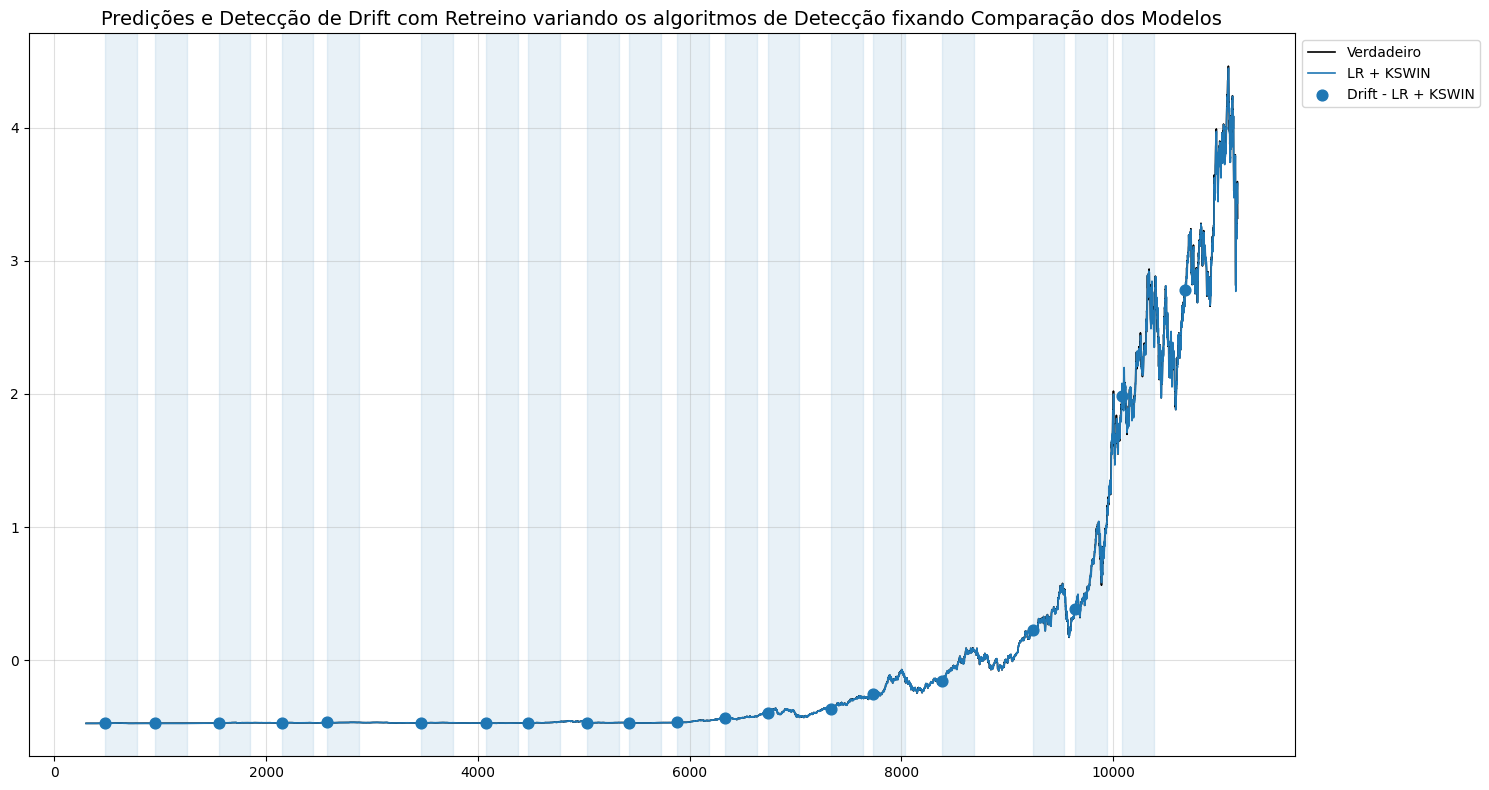

In [17]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_ativo],
                  ["LR + KSWIN"],
                  {"LR + KSWIN": deteccoes_ativo},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )

# **7. Prequential Passivo**

In [18]:
"""avaliador = AvaliadorPassivo()
predicoes_passivo, mae_passivo = avaliador.executar_avaliacao(X, Y, tamanho_batch, OSELMModelo)"""

'avaliador = AvaliadorPassivo()\npredicoes_passivo, mae_passivo = avaliador.executar_avaliacao(X, Y, tamanho_batch, OSELMModelo)'

In [19]:
"""# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_passivo],
                  ["OSELMModelo"],
                  {"OSELMModelo": None},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )"""

'# Plotando os resultados\nVisualizer.plotar_resultados_multi(Y,\n                  [predicoes_passivo],\n                  ["OSELMModelo"],\n                  {"OSELMModelo": None},\n                  tamanho_batch,\n                  detector_or_modelo="Comparação dos Modelos",\n                  )'

# **8. Prequential Passivo com Drift**

In [20]:
"""avaliador = AvaliadorPassivoDrift()
predicoes_ativo_online, deteccoes_ativo_online, mae_ativo_online = avaliador.executar_avaliacao(X, Y, tamanho_batch, LinearRegressionOnlineModelo, KSWINDetector, seed=1)"""

'avaliador = AvaliadorPassivoDrift()\npredicoes_ativo_online, deteccoes_ativo_online, mae_ativo_online = avaliador.executar_avaliacao(X, Y, tamanho_batch, LinearRegressionOnlineModelo, KSWINDetector, seed=1)'

In [21]:
"""# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_ativo_online],
                  ["BayesianLinearRegressionModelo + KSWIN"],
                  {"BayesianLinearRegressionModelo + KSWIN": deteccoes_ativo_online},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )
"""

'# Plotando os resultados\nVisualizer.plotar_resultados_multi(Y,\n                  [predicoes_ativo_online],\n                  ["BayesianLinearRegressionModelo + KSWIN"],\n                  {"BayesianLinearRegressionModelo + KSWIN": deteccoes_ativo_online},\n                  tamanho_batch,\n                  detector_or_modelo="Comparação dos Modelos",\n                  )\n'

# **9. Framework Liedson**

In [22]:
"""framework = OASIS(BayesianLinearRegressionModelo, KSWINDetector, 10, tamanho_batch)
predicoes_frame, deteccoes_frame, mae_frame = framework.prequential(X, Y, tamanho_batch)"""

'framework = OASIS(BayesianLinearRegressionModelo, KSWINDetector, 10, tamanho_batch)\npredicoes_frame, deteccoes_frame, mae_frame = framework.prequential(X, Y, tamanho_batch)'

In [23]:
"""# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_frame],
                  ["Liedson"],
                  {"Liedson": deteccoes_frame},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )"""

'# Plotando os resultados\nVisualizer.plotar_resultados_multi(Y,\n                  [predicoes_frame],\n                  ["Liedson"],\n                  {"Liedson": deteccoes_frame},\n                  tamanho_batch,\n                  detector_or_modelo="Comparação dos Modelos",\n                  )'

# **10. Framework Gabriel**

In [24]:
framework = WinKS(LinearRegressionModelo, LinearRegressionOnlineModelo, KSWINDetector, n_janelas=20, alpha=0.05)
predicoes_frame2, deteccoes_frame2, mae_frame2 = framework.prequential(X, Y, tamanho_batch, seed=0)

477 - 15
1153 - 15
1552 - 15
2140 - 15
2584 - 15
3461 - 15
4248 - 30
4740 - 30
5696 - 15
6104 - 15
6577 - 45
7020 - 15
7418 - 15
7864 - 15
8390 - 15
9371 - 30
9875 - 30
10396 - 15
10973 - 15



Drift detectado para Gabriel nos índices: [477, 1153, 1552, 2140, 2584, 3461, 4248, 4740, 5696, 6104, 6577, 7020, 7418, 7864, 8390, 9371, 9875, 10396, 10973]


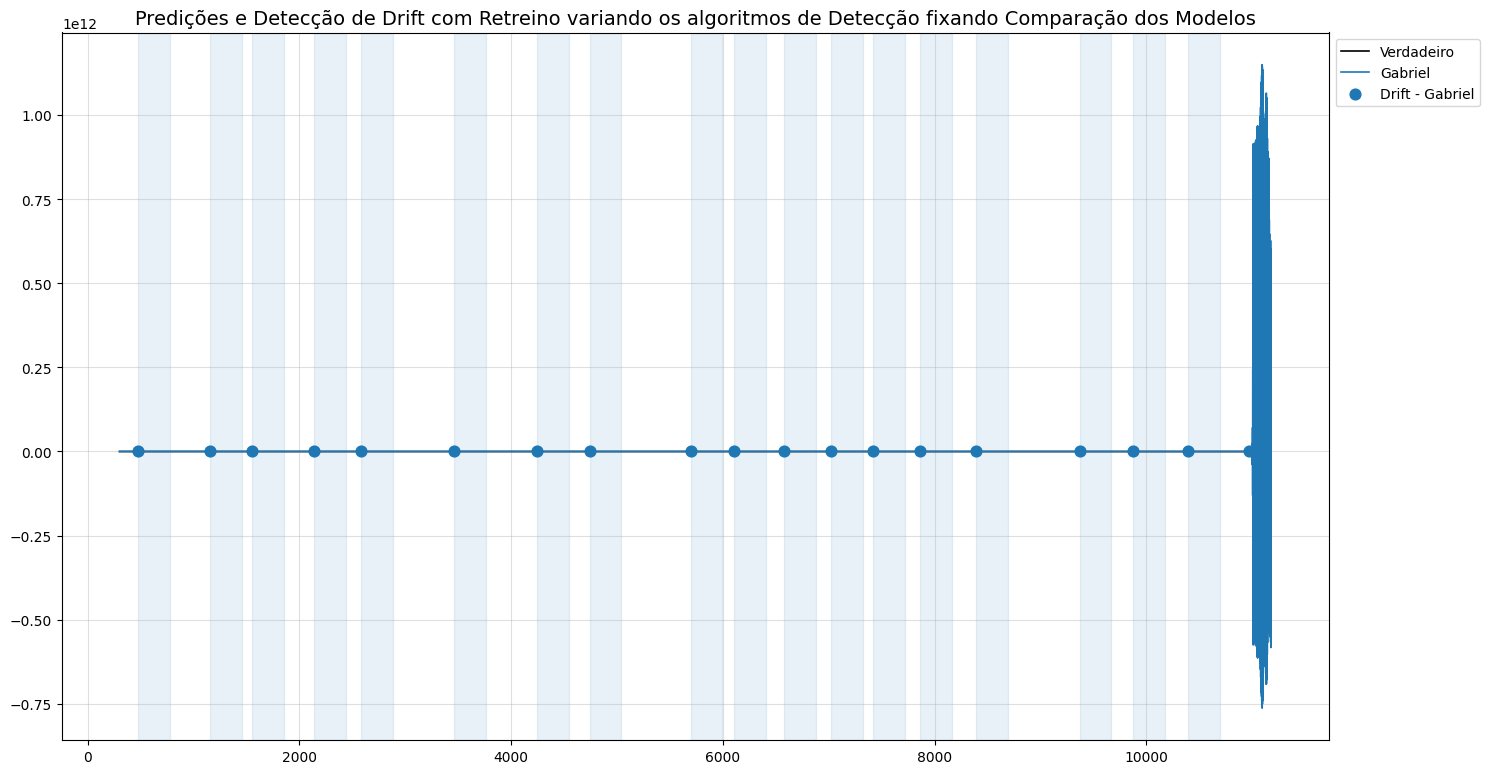

In [25]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_frame2],
                  ["Gabriel"],
                  {"Gabriel": deteccoes_frame2},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )

# **11. Comparação**

In [26]:
print("LR_KSWIN: ", mae_ativo)
#print("OS-ELM: ", mae_passivo)
#print("BayesianOnline: ", mae_ativo_online)
#print("Liedson: ", mae_frame)
print("Gabriel: ", mae_frame2)

LR_KSWIN:  [0.00671541]
Gabriel:  [1.20857696e+10]



Drift detectado para Gabriel nos índices: [477, 1153, 1552, 2140, 2584, 3461, 4248, 4740, 5696, 6104, 6577, 7020, 7418, 7864, 8390, 9371, 9875, 10396, 10973]


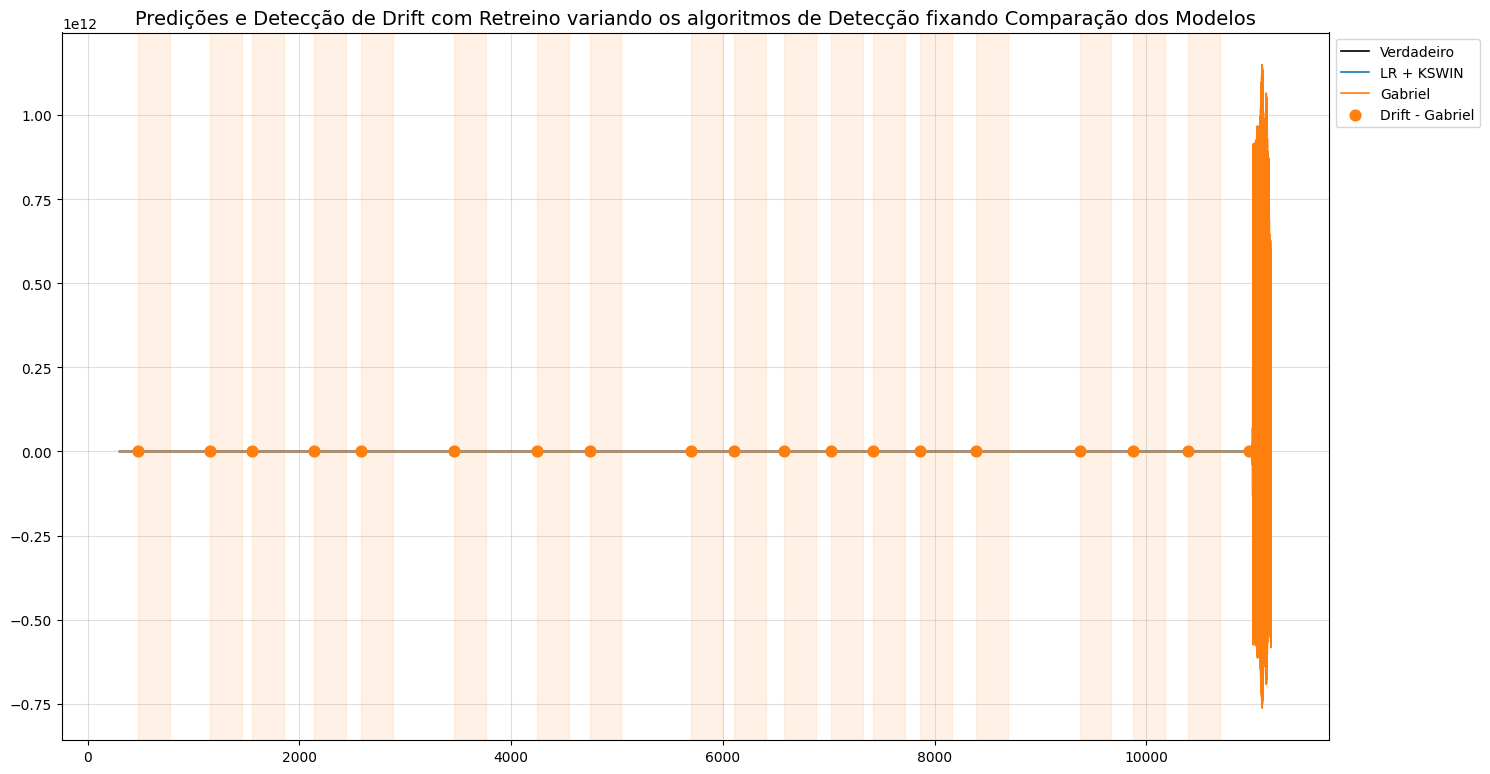

In [27]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_ativo,
                   #predicoes_passivo,
                   #predicoes_ativo_online,
                   #predicoes_frame,
                   predicoes_frame2],
                  ["LR + KSWIN",
                   #"OSELMModelo",
                   #"BayesianLinearRegressionModelo + KSWIN",
                   #"Liedson",
                   "Gabriel"],
                  {"Gabriel": deteccoes_frame2},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )